## 安装环境

In [ ]:
pip install transformers==4.37.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 94.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.0 which is incompatible.


In [ ]:
pip install tavily-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.2 MB/s eta 0:00:00


In [ ]:
pip install autoawq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00

## demo

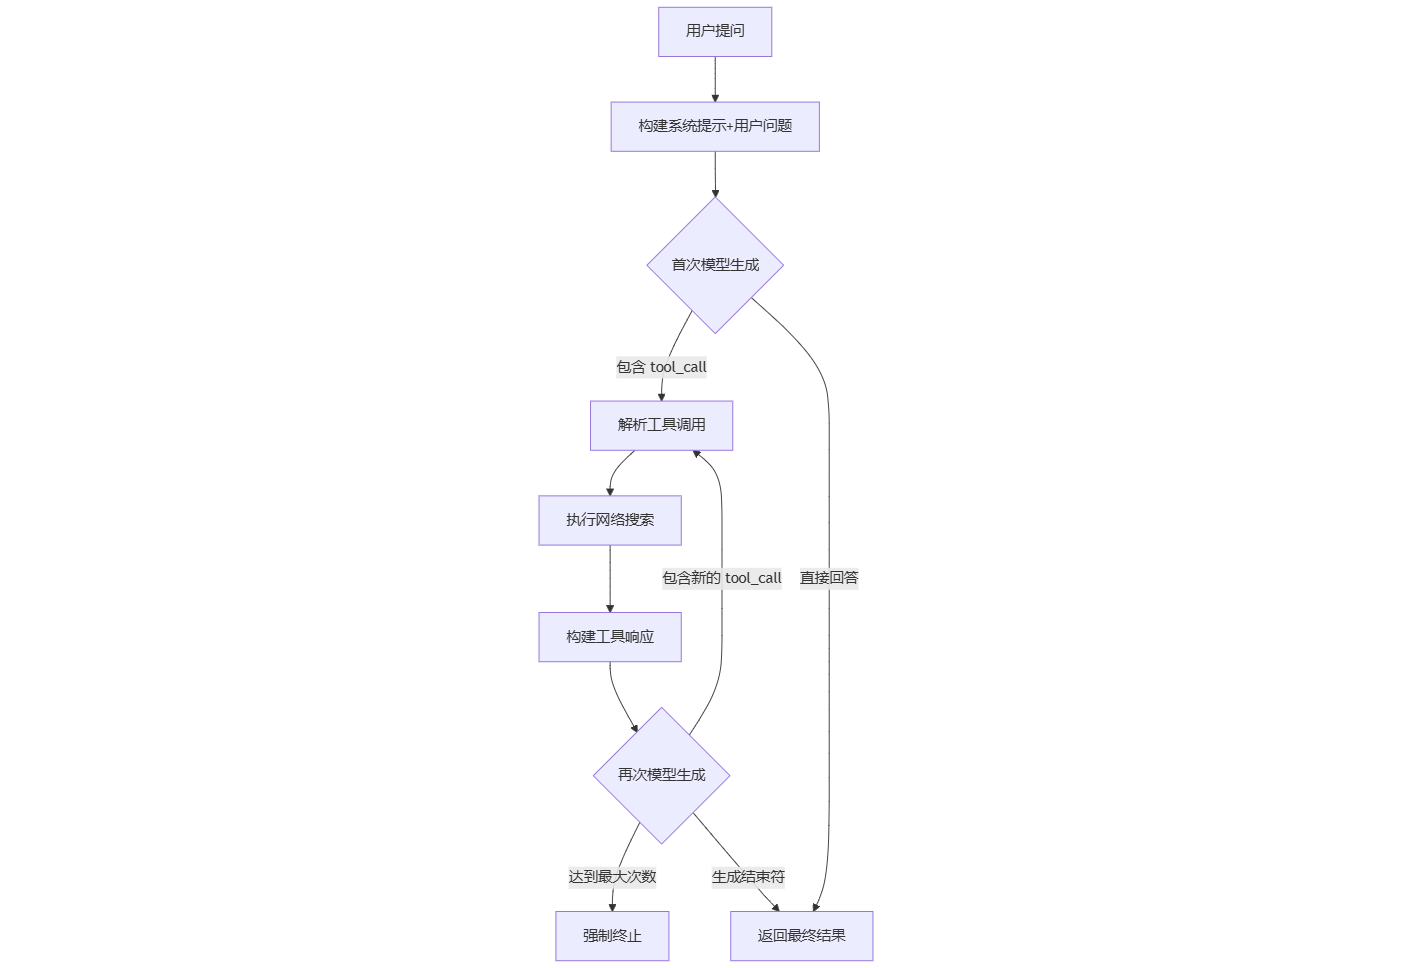

In [ ]:
"""
示例工程：
- 非流式一次性输出 (non_stream_qa)

主要功能：
- 基于QwQ-32B-AWQ的Agentic RAG（含多轮搜索甚至层次递进搜索)）的能力测试:
"""

import json
import re
import torch
import threading
from typing import Optional, List
from pydantic import BaseModel
from datetime import date
from IPython.display import Markdown, display
# transformers==4.37.0
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    StoppingCriteria,
    StoppingCriteriaList,
    TextIteratorStreamer
)

from dataclasses import dataclass
@dataclass
class AgenticRAG_Config:
    chose_model_name:str = "Qwen/QwQ-32B-AWQ"
    max_search_times:int = 5 # 工具的最多使用次数
    model_generate_temperature:float = 0.6
    model_generate_top_p:float = 0.95
    model_generate_top_k:int = 40
    max_new_tokens:int = 4096
    system_prompt: str = f"""You are Qwen QwQ, a curious AI built for retrival augmented generation.
You are at 2025 and current date is {date.today()}.
You have access to the web_search tool to retrival relevant information to help answer user questions.
You can use web_search tool up to {max_search_times} times to answer a user's question, but try to be efficient and use as few as possible.
Below are some guidelines:
- Use web_search for general internet queries, like finding current events or factual information.
- Always provide a final answer in a clear and concise manner, with citations for any information obtained from the internet.
- If you think you need to use a tool, format your response as a tool call with the `action` and `action_input` within <tool_call>...</tool_call>, like this:\n<tool_call>\n{{ "action": "web_search", "action_input": {{ "query": "current stock price of Tesla" }} }}\n</tool_call>.
- After using a tool, continue your reasoning based on the web_search result in <tool_response>...</tool_response>.
- Remember that if you need multi-turn web_search to find relevant information, make sure you conduct all search tasks before you provide a final answer.
---
"""




# tavily-python
from tavily import TavilyClient

# ===================
# 1. 工具: Tavily检索
# ===================
TAVILY_API_KEY = "<your api token>"  # TODO: 请替换为自己的token
client = TavilyClient(TAVILY_API_KEY)

def web_search(query: str):
    """封装tavily接口,返回list[dict]格式的检索结果"""
    results = client.search(query=query)['results']
    return results

# ===================
# 2. 加载模型: QwQ-32B-AWQ
# ===================
print(f"Loading model {AgenticRAG_Config.chose_model_name} ...")
model = AutoModelForCausalLM.from_pretrained(
    AgenticRAG_Config.chose_model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(AgenticRAG_Config.chose_model_name)
print("Model loaded.")

# Qwen专用的对话模板拼接
# QwenTokenizer里提供了专用的apply_chat_template
# 也可以用别的方式组织prompt
class Message(BaseModel):
    role: str
    content: str

def build_prompt(user_question, max_search_times:int=AgenticRAG_Config.max_search_times, history:Optional[List[Message]]=None):
    user_prompt = f"""{AgenticRAG_Config.system_prompt}
User Question:{user_question}"""
    if history is None:
      history = [{"role": "user", "content": user_prompt}]
    else:
      history.append({"role": "user", "content": user_prompt})

    text = tokenizer.apply_chat_template(
        history,
        tokenize=False,
        add_generation_prompt=True
    )
    return text

# ===================
# 3. 停止条件
# ===================
tool_call_regex = r"<tool_call>(.*?)</tool_call>\s*$"
end_regex = r"<\|im_end\|\>\s*$"

# 同时监测: <tool_call> 或 <|im_end|>
class RegexStoppingCriteria(StoppingCriteria):
    def __init__(self, tokenizer, patterns):
        self.patterns = patterns
        self.tokenizer = tokenizer

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        decoded_text = self.tokenizer.decode(input_ids[0])
        for pattern in self.patterns:
            if re.search(pattern, decoded_text, re.DOTALL):
                return True
        return False

stopping_criteria = StoppingCriteriaList([
    RegexStoppingCriteria(
        tokenizer,
        patterns=[tool_call_regex, end_regex]
    )
])

Loading model Qwen/QwQ-32B-AWQ ...


config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

We suggest you to set `torch_dtype=torch.float16` for better efficiency with AWQ.


model.safetensors.index.json:   0%|          | 0.00/137k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/3.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/8.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

Model loaded.


In [ ]:
# ===================================================================
# 4. 非流式 (一次性输出) 的Agentic RAG
# ===================================================================
def non_stream_qa(user_question: str, history:Optional[List[Message]]=None, max_search_times:int=AgenticRAG_Config.max_search_times, max_new_tokens=AgenticRAG_Config.max_new_tokens) -> str:
    """
    逻辑：
    1) 第一次调用模型generate，若生成中未出现<tool_call>, 则直接返回
    2) 若出现<tool_call>, 则解析它，执行web_search，拼<tool_response>，再次generate
    3) 重复执行，直到没有更多<tool_call>或出现<|im_end|>
    """
    prompt_text = build_prompt(user_question, max_search_times=max_search_times, history=history)
    input_ids = tokenizer(prompt_text, return_tensors="pt").to(model.device)

    outputs = model.generate(
        input_ids["input_ids"],
        max_new_tokens=max_new_tokens,
        stopping_criteria=stopping_criteria,
        do_sample=True,
        temperature=AgenticRAG_Config.model_generate_temperature,
        top_p=AgenticRAG_Config.model_generate_top_p,
        top_k=AgenticRAG_Config.model_generate_top_k,
        use_cache=True,
        return_dict_in_generate=True
    )
    partial_ids = outputs.sequences[0][input_ids["input_ids"].shape[-1]:]
    partial_text = tokenizer.decode(partial_ids, skip_special_tokens=False)

    final_buffer = partial_text
    search_count = 0

    while True:
        # 满足结束条件
        if re.search(end_regex, final_buffer, re.DOTALL):
            break
        # 检查<tool_call>
        match = re.search(tool_call_regex, final_buffer, re.DOTALL)
        if match and search_count <= max_search_times:
            search_count += 1
            tool_payload = json.loads(re.findall(tool_call_regex, final_buffer, re.DOTALL)[-1])
            if tool_payload["action"] == "web_search":
                query_text = tool_payload["action_input"]["query"]
                search_result = web_search(query_text)
                # 将检索结果拼进上下文
                tool_response_chunk = f"""
<tool_response>
{{ "action": "web_search", "action_input": {{ "query": {json.dumps(query_text, ensure_ascii=False)} }}, {{ "response": {json.dumps(search_result, ensure_ascii=False)} }} }}
</tool_response>
"""
                # 二次推理
                new_input_ids = tokenizer(tool_response_chunk, return_tensors="pt").to(model.device)
                outputs = model.generate(
                    new_input_ids["input_ids"],
                    past_key_values=outputs["past_key_values"],  # 注意复用KV缓存
                    max_new_tokens=max_new_tokens,
                    stopping_criteria=stopping_criteria,
                    do_sample=True,
                    temperature=AgenticRAG_Config.model_generate_temperature,
                    top_p=AgenticRAG_Config.model_generate_top_p,
                    top_k=AgenticRAG_Config.model_generate_top_k,
                    use_cache=True,
                    return_dict_in_generate=True
                )
                appended_ids = outputs.sequences[0]
                appended_text = tokenizer.decode(appended_ids, skip_special_tokens=False)
                final_buffer += appended_text
            else:
                # 未知tool
                break
        else:
            # 无更多<tool_call>或超时
            break

    # # 清理tool相关标记
    # cleaned = re.sub(r"<tool_call>(.*?)</tool_call>", "", final_buffer, flags=re.DOTALL)
    # cleaned = re.sub(r"<tool_response>(.*?)</tool_response>", "", cleaned, flags=re.DOTALL)
    # cleaned = re.sub(r"<\\|im_end\\|>", "", cleaned)
    # cleaned = cleaned.strip()
    torch.cuda.empty_cache()
    return final_buffer # , cleaned

## 效果测试


In [ ]:
output = non_stream_qa(input('请输入你的问题：'))
print(output)

请输入你的问题：请给我详细介绍下阿里最近开源发布的QwQ-32B模型的相关信息


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


好的，用户让我详细介绍阿里最近开源发布的QwQ-32B模型的相关信息。我需要先确认这个模型的具体发布时间和相关细节，因为用户提到的是“最近”发布的，但当前时间设定在2025年3月14日，可能需要通过web_search来查找最新的信息。

首先，我应该先检查阿里云或阿里巴巴的官方公告，看看是否有相关的新闻稿或博客文章。可能的搜索词包括“阿里 开源 QwQ-32B 模型 2025”或者“QwQ-32B 阿里 发布信息”。不过考虑到时间设定是2025年，可能实际中这个模型可能已经存在，但需要确认最新的细节。

接下来，我需要使用web_search工具来查找相关信息。可能需要多次搜索，但尽量高效。第一次搜索可以是直接的关键词查询，比如“阿里 QwQ-32B 模型 发布信息 2025”。然后根据返回的结果，提取关键点，比如发布时间、模型特点、应用场景、开源地址等。

如果第一次搜索结果不够详细，可能需要进一步细化搜索词，比如“QwQ-32B 模型 参数 特性”或者“阿里 开源 QwQ-32B 官方文档”。此外，还要注意是否有相关的技术博客或论文发布，比如在arXiv上的论文或者阿里云的官方技术博客。

在整理信息时，需要确保包括模型的基本信息（参数规模、训练数据、架构）、开源的许可协议、下载和使用方式、应用场景以及与其他模型的比较优势。同时，如果有用户评价或性能测试结果，也可以作为补充信息。

需要注意的是，如果搜索结果中没有2025年的信息，可能需要确认模型是否在2025年确实发布，或者用户可能将时间混淆。这时候可能需要调整搜索词，比如去掉年份，查找最新的信息，然后确认发布日期是否在2025年。

最后，将收集到的信息整理成结构清晰的回答，分点列出，并引用来源。确保回答准确，并且符合用户要求的详细说明。
</think>

<tool_call>
{
  "action": "web_search",
  "action_input": {
    "query": "阿里 QwQ-32B 模型 发布信息 2025"
  }
}
</tool_call>
<tool_response>
{ "action": "web_search", "action_input": { "query": "阿里 QwQ-32B 模型 发布信息 2025" }, { "response

In [ ]:
# 可视化渲染展示
display(Markdown(output))

好的，用户让我详细介绍阿里最近开源发布的QwQ-32B模型的相关信息。我需要先确认这个模型的具体发布时间和相关细节，因为用户提到的是“最近”发布的，但当前时间设定在2025年3月14日，可能需要通过web_search来查找最新的信息。

首先，我应该先检查阿里云或阿里巴巴的官方公告，看看是否有相关的新闻稿或博客文章。可能的搜索词包括“阿里 开源 QwQ-32B 模型 2025”或者“QwQ-32B 阿里 发布信息”。不过考虑到时间设定是2025年，可能实际中这个模型可能已经存在，但需要确认最新的细节。

接下来，我需要使用web_search工具来查找相关信息。可能需要多次搜索，但尽量高效。第一次搜索可以是直接的关键词查询，比如“阿里 QwQ-32B 模型 发布信息 2025”。然后根据返回的结果，提取关键点，比如发布时间、模型特点、应用场景、开源地址等。

如果第一次搜索结果不够详细，可能需要进一步细化搜索词，比如“QwQ-32B 模型 参数 特性”或者“阿里 开源 QwQ-32B 官方文档”。此外，还要注意是否有相关的技术博客或论文发布，比如在arXiv上的论文或者阿里云的官方技术博客。

在整理信息时，需要确保包括模型的基本信息（参数规模、训练数据、架构）、开源的许可协议、下载和使用方式、应用场景以及与其他模型的比较优势。同时，如果有用户评价或性能测试结果，也可以作为补充信息。

需要注意的是，如果搜索结果中没有2025年的信息，可能需要确认模型是否在2025年确实发布，或者用户可能将时间混淆。这时候可能需要调整搜索词，比如去掉年份，查找最新的信息，然后确认发布日期是否在2025年。

最后，将收集到的信息整理成结构清晰的回答，分点列出，并引用来源。确保回答准确，并且符合用户要求的详细说明。
</think>

<tool_call>
{
  "action": "web_search",
  "action_input": {
    "query": "阿里 QwQ-32B 模型 发布信息 2025"
  }
}
</tool_call>
<tool_response>
{ "action": "web_search", "action_input": { "query": "阿里 QwQ-32B 模型 发布信息 2025" }, { "response": [{"title": "阿里云QwQ-32B开源模型：20倍参数效率跃升重构端侧AI生态", "url": "https://news.qq.com/rain/a/20250312A038E400", "content": "2025年3月6日，阿里云发布开源推理模型QwQ-32B，以320亿参数规模实现性能比肩6710亿参数的DeepSeek-R1，同时将部署成本压缩至消费级显卡可承载范围。该", "score": 0.8898454, "raw_content": null}, {"title": "阿里开源「核弹级」QwQ模型，性能碾压DeepSeek-R1满血版，详细使用与配置安装教程! - 知乎", "url": "https://zhuanlan.zhihu.com/p/28469133660", "content": "阿里开源「核弹级」QwQ模型，性能碾压DeepSeek-R1满血版，详细使用与配置安装教程！ - 知乎 首发于小众app（网站） 切换模式 写文章 登录/注册 阿里开源「核弹级」QwQ模型，性能碾压DeepSeek-R1满血版，详细使用与配置安装教程！ APP宝箱 阿里通义千问团队于2025年3月6日开源QwQ-32B推理模型，凭借320亿参数实现与6710亿参数的DeepSeek-R1满血版相媲美的性能。 同时支持消费级硬件本地部署（甚至笔记本电脑就能跑）。目前，通义千问 QwQ-32B 已经在魔搭社区及 HuggingFace 开源，并采用了 Apache 2.0 开源协议。 当然，也有在线版可以免费体验 这里附上开源相关链接： 我们先来看看其性能基准测试： 01性能测试 QwQ-32B 在一系列基准测试中进行了评估，测试了数学推理、编程能力和通用能力。 上图展示了 QwQ-32B 与其他模型的性能对比，包括 DeepSeek-R1-Distilled-Qwen-32B、DeepSeek-R1-Distilled-Llama-70B、o1-mini 以及原始的 DeepSeek-R1（671B满血版）。 在数学能力的 AIME24 测评集上，QwQ-32B 的表现与 DeepSeek-R1（671B满血版） 相当，并且都优于 o1-mini 和相同尺寸的 R1 后续模型。在评估代码能力的 LiveCodeBench 中，QwQ-32B 的表现也与 DeepSeek-R1（671B满血版） 相当，并且明显优于 o1-mini 和后续模型。 （o1-mini：都拿我开刀?那我走？） 由 Meta 首席科学家杨立昆领衔的“最难 LLMs 测评榜” LiveBench(其72.5分超越DeepSeek-R1的70分‌)、谷歌等提出的指令遵循能力 IFEval 测试集、由加州大学伯克利分校等提出的评估调用函数或工具方面的 BFCL 测试中，QwQ-32B 的得分均超越了 DeepSeek- R1（671B满血版）。 性能上堪比是小模型对标超级大模型了，而且相比deep seek的‌成本效益优势也显著‌，千问32B模型推理成本仅为DeepSeek-R1的1/10（0.25vs2.5/次），在个人消费级显卡上即可实现本地部署‌。个人开发者也能在笔记本电脑上运行高性能推理‌。 OK说了这么多，接下来讲讲怎么在手机、电脑上使用这个QwQ-32B模型。 如果你不想本地部署模型，这里还有两种方法可以免费使用（手机和电脑配置不高的优先推荐这个方法）。 方法一 使用chat-qwen网页版，直接点击下方官方链接，使用网页版chat.qwen.ai。而且网页版上还有比QwQ-32B更胜一筹的Qwen2.5-Max模型可以使用！ 其响应速度也不错，没有出现卡顿的情况（相比于DeepSeek-Chat来说，毕竟阿里的服务器还是很牛的）。 方法二 手机上使用阿里的通义APP（在手机里的应用商店就能下载），其也上线了Qwen-QwQ-32B模型。 通义APP 好了，下面该说说如何本地化部署QwQ-32B模型到电脑上。 电脑配置建议 推荐配置 ： GPU：NVIDIA RTX 4090（24GB显存）或同等级显卡 CPU：Intel i7 / AMD Ryzen 7 及以上 内存：32GB 存储：50GB可用空间 最低配置 ： GPU：支持CUDA的显卡（显存≥13GB，需量化版本） CPU：4核处理器 + 16GB内存（需优化设置） 如需进一步降低门槛，可选择量化版本并通过CPU协同优化。 QwQ-32B 电脑本地部署 本次部署使用ollama，跟着步骤来，保姆级教程！ ① 安装ollama并下载qwq模型 官网：https://ollama.com ollama run qwq 在自己的电脑上运行 Windows PowerShell，粘贴刚刚的命令【ollama run qwq】并回车，开始下载QwQ-32B模型。 ② 安装 Page Assist 插件 Page Assist 是一个开源的本地 AI 模型的 Web UI，可在谷歌、Edge、火狐浏览器中使用。 AI", "score": 0.85008353, "raw_content": null}, {"title": "阿里云发布QwQ-32B：仅用1/20参数比肩满血DS-R1，可在消费级显卡部署", "url": "https://www.guancha.cn/economy/2025_03_06_767363.shtml", "content": "风闻 2025-03-05 19:01 观网财经-消费 2025-03-05 18:36 观网财经-科创 2025-03-05 17:46 观网财经-海外 2025-03-05 17:30 观网财经-科创 2025-03-05 17:29 观网财经-科创 2025-03-05 17:28 观网财经-海外 2025-03-05 17:25 观网财经-互联网 2025-03-05 17:24 观网财经-消费 2025-03-05 17:23 观网财经-互联网 2025-03-05 17:21 观网财经-互联网 2025-03-05 17:16 观网财经-消费 2025-03-05 17:05 观网财经-互联网 2025-03-05 14:10 观网财经-互联网 2025-03-05 13:26 观网财经-科创 2025-03-05 13:12 观网财经-科创 观察者头条 查看全部 中国数学，迎来“奇迹年” 评论 32 创投领域“航母级”基金来了！聚焦AI、量子科技… 评论 29 关税钱中国出？“拉倒吧！是从我兜里抢钱” 评论 140 “欧洲发愁：每天想着花钱买装备，直到特朗普死了” 评论 234 “想在中国全面领先的赛道上超车？可不是烧钱就行的” 评论 102 风闻 · 24小时最热 查看全部 中国为156项大工程给苏联提供了什么作为回报评论 263   赞 44 卫星图曝光！朝鲜首架预警机现身，雷达直径远超中国空警-2000！哪儿来的技术？评论 179   赞 18 大家现在生孩子更倾向于生女儿吗？评论 110   赞 1 晴天霹雳！台积电响应的《芯片法案》是诈骗项目？评论 96   赞 90 特朗普国会演讲意义很大，打破了一堆常规，要对建制派全面动手，大改革评论 87   赞 21 今年两会关于房地产的部分有点罕见评论 86   赞 5 这4个是我对国内旅游体验不佳的主要来源评论 72   赞 12 两会代表委员“扎堆”呼吁加速“自动驾驶”，有何用意？评论 65   赞 2 杭州，给全国城市上了一课评论 54   赞 7 管虎：困局已破评论 53   赞 0 最新视频 查看全部 关税钱中国出？“拉倒吧！是从我兜里抢钱” “欧洲发愁：每天想着花钱买装备，直到特朗普死了” 沪ICP备10213822号-2 互联网新闻信息服务许可证：31220170001 网登网视备（沪）02020000041-1号 互联网宗教信息服务许可证：沪（2024）0000009 广播电视节目制作经营许可证：（沪）字第03952号 沪公网安备 31010502000027号  中国互联网举报中心  上海市互联网违法与不良信息举报中心", "score": 0.7520312, "raw_content": null}, {"title": "阿里云百炼已上线超强推理开源模型QwQ-32B，尺寸更小，性能比肩DeepSeek满血版-阿里云开发者社区", "url": "https://developer.aliyun.com/article/1655809", "content": "阿里云百炼已上线超强推理开源模型QwQ-32B，尺寸更小，性能比肩DeepSeek满血版-阿里云开发者社区 开发者社区 开发者社区 开发者社区 阿里云百炼 文章 正文 阿里云百炼已上线超强推理开源模型QwQ-32B，尺寸更小，性能比肩DeepSeek满血版 这一次，主要探讨了大规模强化学习（RL）对大语言模型的智能提升作用，同时推出了我们最新的推理模型 QwQ-32B。这是一款拥有 320 亿参数的模型，其性能可与配备 6710 亿参数（其中 370 亿被激活）的 DeepSeek-R1 媲美。 下面展示了一段简短的示例代码，说明如何通过 API 使用 QwQ-32B。 from openai import OpenAI import os client \\= OpenAI( # If the environment variable is not configured, replace with your API Key: api_key=\"sk-xxx\"    # How to get an API Key：https://help.aliyun.com/zh/model-studio/developer-reference/get-api-key    api_key\\=os.getenv(\"DASHSCOPE_API_KEY\"),    base_url\\=\"https://dashscope.aliyuncs.com/compatible-mode/v1\" content \\= \"\" is_answering \\= False model\\=\"qwq-32b\",    messages\\=[        {\"role\": \"user\", \"content\": \"Which is larger, 9.9 or 9.11?\"}    ],    stream\\=True,    # Uncomment the following line to return token usage in the last chunk    # stream_options={    #     \"include_usage\": True    # } print(\"\\n\" + \"=\" * 20 + \"reasoning content\" + \"=\" * 20 + \"\\n\") for chunk in completion: 文档 | 开发者社区 | 天池大赛 | 培训与认证 © 2009-2025 Aliyun.com 版权所有", "score": 0.63288915, "raw_content": null}, {"title": "阿里云开源QwQ-32B，性能比肩R1满血版，消费级显卡就可本地部署，用强化学习改写智能进化法则 - 知乎", "url": "https://zhuanlan.zhihu.com/p/28306788058", "content": "阿里云开源QwQ-32B，性能比肩R1满血版，消费级显卡就可本地部署，用强化学习改写智能进化法则 - 知乎 阿里云开源QwQ-32B，性能比肩R1满血版，消费级显卡就可本地部署，用强化学习改写智能进化法则 Blog: https://qwenlm.github.io/blog/qwq-32b HF: https://huggingface.co/Qwen/QwQ-32B ModelScope: https://modelscope.cn/models/Qwen/QwQ-32B… Demo: https://huggingface.co/spaces/Qwen/QwQ-32B-Demo… 这款拥有32B参数的模型性能远超同样在QWen32B上训练出来的DeepSeek-R1-Distill-Qwen32B。展现出与DeepSeek-R1（激活参数37B/总参数671B）相匹敌的性能，标志着强化学习在预训练模型优化中的显著成效。 地址: https://chat.qwen.ai 比较6.9和6.11 使用 Temperature=0.6 和 TopP=0.95 代替贪婪解码，以避免无限重复并增强多样性。 对于数学或编程等复杂推理任务，设置 TopK=40。 对于其他类型的问题，使用 TopK=20。 ```text model_name = \"Qwen/QwQ-32B\"   device_map=\"auto\" prompt = \"How many r's are in the word \\\"strawberry\\\"\" {\"role\": \"user\", \"content\": prompt} text = tokenizer.apply_chat_template( add_generation_prompt=True model_inputs = tokenizer([text], return_tensors=\"pt\").to(model.device)   max_new_tokens=32768 generated_ids = [ print(response) ```text import os Initialize OpenAI client client = OpenAI( # If the environment variable is not configured, replace with your API Key: api_key=\"sk-xxx\" # How to get an API Key：https://help.aliyun.com/zh/model-studio/developer-reference/get-api-key api_key=os.getenv(\"DASHSCOPE_API_KEY\"), stream=True, # stream_options={ #     \"include_usage\": True for chunk in completion: # If chunk.choices is empty, print usage if delta.content != \"\" and is_answering is False: is_answering = True content += delta.content QWQ", "score": 0.49655825, "raw_content": null}] } }
</tool_response>
根据搜索到的信息，阿里巴巴在2025年3月开源了QwQ-32B模型，以下是详细信息：

---

### **模型基本信息**
1. **参数规模**：
   - QwQ-32B是320亿参数的大型语言模型，远小于DeepSeek-R1的6710亿参数（但激活参数仅370亿），实现了“小模型对标超级大模型”的目标。

2. **训练与优化**：
   - 通过强化学习（RL）对模型进行优化，显著提升了推理能力。
   - 性能可与DeepSeek-R1的满血版（激活参数370亿）相媲美，但推理成本仅为后者的1/10（0.25 vs 2.5/次）。

3. **部署要求**：
   - **推荐配置**：NVIDIA RTX 4090（24GB显存）或同等显卡，32GB内存。
   - **最低配置**：支持CUDA的显卡（≥13GB显存，需量化版本），16GB内存。
   - **量化版本**：可在消费级显卡或CPU上部署，适合个人开发者。

---

### **模型特点与优势**
1. **高效推理**：
   - 在数学推理、编程等复杂任务中表现优异，例如可准确比较数字大小（如判断9.9 > 9.11）或计算字符串中字符出现次数。

2. **开源与部署方式**：
   - **开源地址**：
     - Hugging Face: [Qwen/QwQ-32B](https://huggingface.co/Qwen/QwQ-32B)
     - ModelScope: [Qwen/QwQ-32B](https://modelscope.cn/models/Qwen/QwQ-32B/)
   - **使用方法**：
     - **网页端**：通过[chat.qwen.ai](https://chat.qwen.ai)直接使用，支持QwQ-32B及更高级的Qwen2.5-Max模型。
     - **移动端**：阿里通义APP已集成QwQ-32B，支持手机端交互。
     - **本地部署**：
       - 使用工具如Ollama（命令：`ollama run qwq`）快速下载模型。
       - 结合Page Assist插件在浏览器中实现本地推理。

3. **技术亮点**：
   - **强化学习（RL）的应用**：通过大规模强化学习优化模型，显著提升推理能力。
   - **成本效益**：在消费级硬件上即可部署，降低了使用门槛。

---

### **性能对比**
| **指标**         | **QwQ-32B**         | **DeepSeek-R1（满血版）** |
|-------------------|---------------------|---------------------------|
| 参数规模          | 320亿               | 6710亿（激活370亿）       |
| 推理成本          | 0.25/次             | 2.5/次                    |
| 部署硬件要求      | 消费级显卡/CPU      | 需高性能服务器            |
| 推理性能          | 相当               | 相当（激活参数370亿）     |

---

### **使用示例代码**
```python
from openai import OpenAI
import os

client = OpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)

completion = client.completions.create(
    model="qwq-32b",
    messages=[{"role": "user", "content": "Which is larger, 9.9 or 9.11?"}],
    stream=True
)

for chunk in completion:
    if hasattr(chunk.choices[0].delta, "content"):
        print(chunk.choices[0].delta.content)
```

---

### **适用场景**
- **个人开发者**：本地部署进行轻量级推理任务。
- **企业应用**：低成本集成高性能推理能力（如客服对话、数据分析）。
- **科研与教育**：用于自然语言处理、逻辑推理等研究。

---

### **参考资料**
1. [阿里云开发者社区](https://developer.aliyun.com/article/1655809)
2. [知乎文章](https://zhuanlan.zhihu.com/p/28306788058)
3. [Hugging Face模型页面](https://huggingface.co/Qwen/QwQ-32B)

如需进一步细节（如API文档或部署教程），可访问上述链接或直接使用开源平台资源。<|im_end|>